# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.012777,False,-3.042986
1,0.289858,False,1.112130
2,1.347723,True,8.063621
3,-0.464752,False,-0.189419
4,0.121820,False,-0.439537
...,...,...,...
995,-1.797895,False,-4.532083
996,-1.601010,False,-4.809766
997,-0.639639,False,-1.936961
998,-2.256174,False,-5.319564


<Axes: xlabel='v0'>

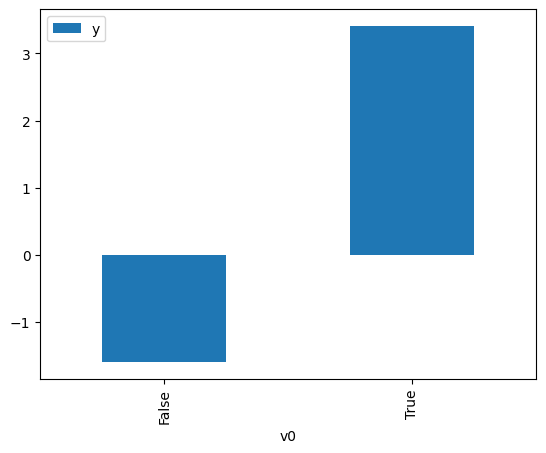

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

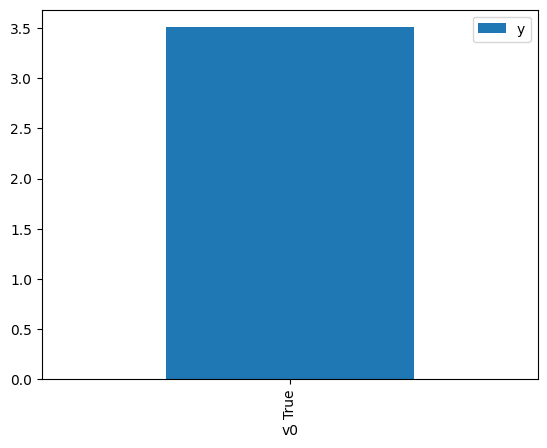

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.304858,False,-1.448515,0.532390,1.878323
1,-0.625992,False,-2.489382,0.594945,1.680829
2,0.918621,False,2.341392,0.301398,3.317870
3,-0.650677,False,-1.249433,0.599654,1.667629
4,0.232127,False,0.969079,0.426496,2.344690
...,...,...,...,...,...
995,-0.486277,False,-1.746970,0.567984,1.760612
996,-0.994063,False,-0.910734,0.662929,1.508456
997,-0.600021,False,-0.240069,0.589971,1.694998
998,-1.467687,False,-3.689877,0.741164,1.349230


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.540636,True,3.159776,0.421469,2.372652
1,-0.517413,True,4.373290,0.425967,2.347601
2,-1.011418,True,3.547779,0.334002,2.993996
3,-1.705678,True,-0.387705,0.224299,4.458329
4,-1.809141,True,-0.779102,0.210345,4.754091
...,...,...,...,...,...
995,-0.207755,True,5.120488,0.486822,2.054139
996,-0.597498,True,3.878264,0.410513,2.435976
997,0.806819,True,7.124728,0.679609,1.471435
998,-1.339661,True,3.927840,0.278788,3.586958


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                              7593.
Date:                Tue, 05 Sep 2023   Prob (F-statistic):                        0.00
Time:                        05:11:13   Log-Likelihood:                         -1418.2
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3582      0.028     85.636      0.000       2.304       2.412
x2             5.0888      0.050    101.283      0.000       4.990       5.187
==============================================================================
Omnibus:                        5.587   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.476
Skew:                          -0.177   Prob(JB):                       0.0647
Kurtosis:                       3.080   Cond. No.                         1.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""